In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime, timedelta
from tqdm import tqdm
import missingno as msno
import zipfile

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

archivo_csv = 'fact_licitacion-2007_2023-full.csv'
directorio_data = 'data/'

In [2]:
ruta_archivo = directorio_data + archivo_csv
df_csv = pd.read_csv(ruta_archivo, encoding="ISO-8859-1", delimiter=",")
df_csv.shape

(12126458, 11)

In [3]:
df = df_csv.copy()

In [4]:
df.head()

,id_fecha,id_rubro,id_sector,id_organismo,id_unidad,id_producto,id_zona,codigo_moneda,cantidad_adjudicada,monto_unitario_oferta_usd,monto_adjudicado_usd
0,20070105,1986,5,100523,3762,51101720,8103,2,100.0,1.813102,181.310244
1,20070105,1986,5,100523,3762,51101720,8103,2,100.0,0.499528,49.952822
2,20070105,483,5,100523,3762,51101811,8103,2,6000.0,0.035152,210.911917
3,20070105,483,5,100523,3762,51101815,8103,2,20.0,2.386635,47.732697
4,20070105,483,5,100523,3762,51101815,8103,2,100.0,0.536530,53.653031


In [5]:
df.shape

(12126458, 11)

In [6]:
# Convertir 'id_fecha' a formato de fecha y ordenar de forma ascendente
df['id_fecha'] = pd.to_datetime(df['id_fecha'], format='%Y%m%d')
df = df.sort_values(by='id_fecha')

In [7]:
# 1. Crear características de fecha
df['mes'] = df['id_fecha'].dt.month
df['trimestre'] = df['id_fecha'].dt.quarter
df['anio'] = df['id_fecha'].dt.year

In [8]:
df.head()

,id_fecha,id_rubro,id_sector,id_organismo,id_unidad,id_producto,id_zona,codigo_moneda,cantidad_adjudicada,monto_unitario_oferta_usd,monto_adjudicado_usd,mes,trimestre,anio
0,2007-01-05,1986,5,100523,3762,51101720,8103,2,100.0,1.813102,181.310244,1,1,2007
1,2007-01-05,1986,5,100523,3762,51101720,8103,2,100.0,0.499528,49.952822,1,1,2007
2,2007-01-05,483,5,100523,3762,51101811,8103,2,6000.0,0.035152,210.911917,1,1,2007
3,2007-01-05,483,5,100523,3762,51101815,8103,2,20.0,2.386635,47.732697,1,1,2007
4,2007-01-05,483,5,100523,3762,51101815,8103,2,100.0,0.536530,53.653031,1,1,2007


In [9]:
# Agrupa y suma la cantidad de productos por zona
df_group = df.groupby(['anio','mes','id_zona','id_unidad','id_producto','id_sector'])['cantidad_adjudicada'].sum().reset_index()
df_group

,anio,mes,id_zona,id_unidad,id_producto,id_sector,cantidad_adjudicada
0,2007,1,3,5400,42143513,5,1.0
1,2007,1,5,1604,20121301,2,2300.0
2,2007,1,5,1604,31201512,2,120.0
3,2007,1,5,1604,41121707,2,200.0
4,2007,1,5,1604,41121803,2,4.0
...,...,...,...,...,...,...,...
6372870,2023,6,16305,5622,30222116,5,1.0
6372871,2023,6,16305,5622,51141604,5,600.0
6372872,2023,6,16305,5622,51181517,5,140000.0
6372873,2023,6,16305,5622,73171507,5,2.0


In [10]:
df_group['a_m_z_u_p_s'] = df_group['anio'].astype(str) + '_' + df_group['mes'].astype(str) + '_' + df_group['id_zona'].astype(str) + '_' + df_group['id_unidad'].astype(str) + '_' + df_group['id_producto'].astype(str) + '_' + df_group['id_sector'].astype(str)
df_group['a_m_z_u_p_s'].dtype

dtype('O')

In [11]:
df_group = df_group.drop(columns=['anio','mes','id_zona','id_unidad','id_producto','id_sector'])
df_group.head()

,cantidad_adjudicada,a_m_z_u_p_s
0,1.0,2007_1_3_5400_42143513_5
1,2300.0,2007_1_5_1604_20121301_2
2,120.0,2007_1_5_1604_31201512_2
3,200.0,2007_1_5_1604_41121707_2
4,4.0,2007_1_5_1604_41121803_2


In [ ]:
#df = df.drop(columns=['monto_unitario_oferta_usd','monto_adjudicado_usd'])
#df.head()

In [ ]:
#df_dim_temporal = df['unida_producto_zona'].drop_duplicates()
#print(len(df_dim_temporal))

In [12]:
dtypes = df_group.dtypes
column_types = pd.DataFrame({'Columna': dtypes.index, 'Tipo': dtypes.values})
column_types

,Columna,Tipo
0,cantidad_adjudicada,float64
1,a_m_z_u_p_s,object


In [16]:
#los valores de cantidades deben ser valores enteros
#col_set_int = ['id_producto','mes','anio','id_unidad','id_zona','id_sector']

col_set_int = ['cantidad_adjudicada']

for col in col_set_int:
    antes = df_group[col].dtype
    df_group[col] = df_group[col].astype(int)
    despues = df_group[col].dtype
    print(f'{col} : {antes} -> {despues}')

cantidad_adjudicada : int32 -> int32


In [17]:
dtypes = df_group.dtypes
column_types = pd.DataFrame({'Columna': dtypes.index, 'Tipo': dtypes.values})
column_types

,Columna,Tipo
0,cantidad_adjudicada,int32
1,a_m_z_u_p_s,object


In [20]:
df_group.shape

(6372875, 2)

In [18]:
df_bkp = df_group.copy()

In [21]:
df_bkp.head()

,cantidad_adjudicada,a_m_z_u_p_s
0,1,2007_1_3_5400_42143513_5
1,2300,2007_1_5_1604_20121301_2
2,120,2007_1_5_1604_31201512_2
3,200,2007_1_5_1604_41121707_2
4,4,2007_1_5_1604_41121803_2


In [22]:
df_bkp.duplicated().sum()

0

In [23]:
# Separamos las variables independientes y dependiente
X_df = df_bkp.drop(columns=['cantidad_adjudicada'])
y_df = df_bkp['cantidad_adjudicada']
print(f'X: {X_df.shape} y: {y_df.shape}')

X: (6372875, 1) y: (6372875,)


In [24]:
X_df.head()

,a_m_z_u_p_s
0,2007_1_3_5400_42143513_5
1,2007_1_5_1604_20121301_2
2,2007_1_5_1604_31201512_2
3,2007_1_5_1604_41121707_2
4,2007_1_5_1604_41121803_2


In [25]:
y_df.head()

0       1
1    2300
2     120
3     200
4       4
Name: cantidad_adjudicada, dtype: int32

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f'Tamaño set de entrenamientos: X: {X_train.shape} y: {y_train.shape}')
print(f'Tamaño set de validacion: X: {X_valid.shape} y: {y_valid.shape}')
print(f'Tamaño set de prueba: X: {X_test.shape} y: {y_test.shape}')

Tamaño set de entrenamientos: X: (5098300, 1) y: (5098300,)
Tamaño set de validacion: X: (637287, 1) y: (637287,)
Tamaño set de prueba: X: (637288, 1) y: (637288,)


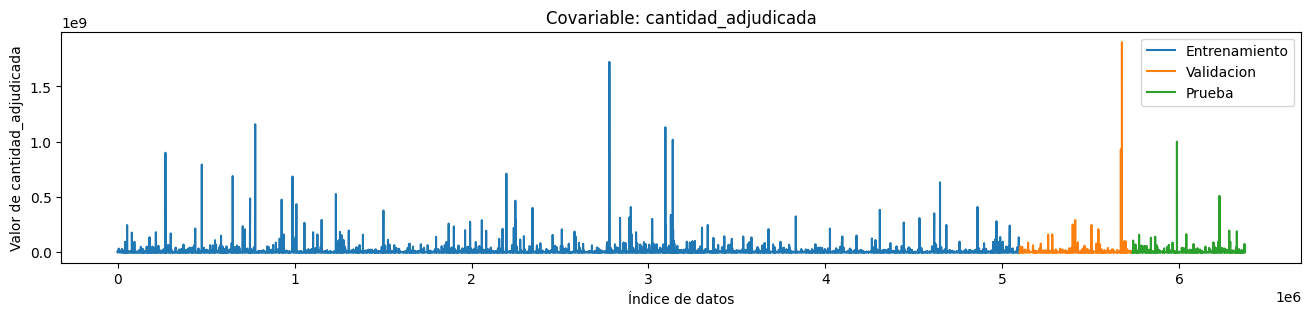

In [27]:
# Crear un índice para los datos de entrenamiento y prueba
indice_entrenamiento = range(len(y_train))
indice_valid = range(len(y_train), len(y_train) + len(y_valid))
indice_prueba = range(len(y_train) + len(y_valid), len(y_train) + len(y_test) + len(y_valid))

fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(indice_entrenamiento, y_train, label='Entrenamiento')
ax.plot(indice_valid, y_valid, label='Validacion')
ax.plot(indice_prueba, y_test, label='Prueba')
ax.set_title('Covariable: cantidad_adjudicada')
ax.set_xlabel('Índice de datos')
ax.set_ylabel('Valor de cantidad_adjudicada')
plt.legend()
plt.show()

In [28]:
score_models = []
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()
X_test_scaled = X_test.copy()

In [29]:
# Aplicar Min-Max Scaling a las características (X)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

#for col in X_train.columns:
#    print(col)
#    X_train_scaled[col] = np.log1p(X_train_scaled[col])
#    X_valid_scaled[col] = np.log1p(X_valid_scaled[col])
#    X_test_scaled[col] = np.log1p(X_test_scaled[col])

In [30]:
df_train_scaled = pd.DataFrame(X_train_scaled, columns=[X_train.columns])
df_train_scaled.head()

,a_m_z_u_p_s
0,9.947583e-06
1,9.944626e-06
2,9.944577e-06
3,9.937708e-06
4,9.963762e-07


### Redes Neuronales

In [31]:
np.random.seed(461)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model_nn = keras.Sequential([
    Dense(64, input_shape=(X_train_scaled.shape[1],)),
    Dense(1)
])

learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model_nn.compile(loss='mean_squared_error', optimizer=optimizer)

#model_nn.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193 (772.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
#score = model_nn.fit(X_train_scaled, y_train, epochs=50, batch_size=64, verbose=1, shuffle=True)
score = model_nn.fit(X_train_scaled, y_train, epochs=100, batch_size=64, validation_data=(X_valid_scaled, y_valid), verbose=1, shuffle=True)

Epoch 1/100
24934/79661 [========>.....................] - ETA: 1:41 - loss: 3740832366592.0000

KeyboardInterrupt: 

In [ ]:
score_models.append(score)
print("SCORE: [%s] " % score)

### Regresión Lineal


In [33]:
np.random.seed(461)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
score = model_lr.score(X_valid_scaled, y_valid)
score_models.append(score)
print("SCORE: [%s] " % score)

SCORE: [-3.836147199898221e-08] 


### Regresión de Máquinas de Soporte Vectorial (SVM)

In [ ]:
np.random.seed(461)
from sklearn.svm import SVR

model_svm = SVR()
model_svm.fit(X_train_scaled, y_train)
score = model_svm.score(X_valid_scaled, y_valid)
score_models.append(score)
print("SCORE: [%s] " % score)

### Regresión de Bosques Aleatorios


In [ ]:
np.random.seed(461)
from sklearn.ensemble import RandomForestRegressor

model_RF_Regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=7)
model_RF_Regressor.fit(X_train_scaled, y_train)
score = model_RF_Regressor.score(X_valid_scaled, y_valid)
score_models.append(score)
print("SCORE: [%s] " % score)

#### Regresion logistica

In [ ]:
np.random.seed(461)
from sklearn.linear_model import LogisticRegression

model_rl = LogisticRegression()
model_rl.fit(X_train_scaled, y_train)
score = model_rl.score(X_valid_scaled, y_valid)
score_models.append(score)
print("SCORE: [%s] " % score)


In [ ]:
print(score_models)

In [34]:
from sklearn.metrics import r2_score

predictions = model_lr.predict(X_valid_scaled)
r2 = r2_score(y_valid, predictions)
print("R^2 Score: %.2f" % r2)

R^2 Score: -0.00
